# Generic Cross-Band RFI Attenuation Analysis  
### S, X, Ku, K, and Ka Bands under Identical Interference Assumptions

This notebook implements a generic Radio Frequency Interference (RFI) analysis framework
for space communication links operating in the S, X, Ku, K, and Ka bands.

ITU-R Recommendations are used **exclusively as methodological references**
for propagation, antenna patterns, aggregation, and statistical modeling.
The objective of this notebook is **comparative analysis**, not regulatory assessment.

The primary quantity of interest is the **interference-induced attenuation**
expressed as SNR loss:

\[
\Delta \mathrm{SNR} = \mathrm{SNR}_0 - \mathrm{SNR}_{\mathrm{I}}
\]


## 1. Model Overview

The analysis uses a single band-agnostic RFI model.
Only numerical parameters such as frequency, antenna gain, bandwidth,
and geometry vary between bands.

The model consists of:

- Free-space propagation (ITU-R P.525)
- Off-axis antenna discrimination (ITU-R S.1528-type pattern)
- Aggregate interference summation (ITU-R S.1325 methodology)
- Statistical variability using log-normal interference samples
  (ITU-R SA.1157-style formulation)

The output metrics are purely **descriptive** and focus on:
- Baseline SNR
- SNR degradation due to aggregate interference
- Variability and exceedance probabilities


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Ensure local package visibility
current_dir = os.path.dirname(os.path.abspath(""))
sys.path.append(current_dir)
sys.path.append(os.path.join(current_dir, "rfi"))

from rfi.scenario import run_multi_entry_rfi_scenario
from rfi.itu_models import (
    compute_thermal_noise_dbw,
    free_space_path_loss_db,
    compute_interference_power_dbw,
    compute_snr_with_interference_db,
    compute_off_axis_gain_s1528_db,
    generate_geometric_sweep,
)


## 2. Global Assumptions

To ensure fair comparison across frequency bands,
all links are evaluated under identical geometric
and interference assumptions unless explicitly stated.

All frequency bands are evaluated under identical interference geometry,
emission characteristics, and deployment assumptions to enable direct
cross-band comparison of RFI-induced attenuation.

The following constants are used throughout the notebook:


In [2]:
DKM_GEO = 35786.0        # km, nominal GEO slant range
T_SYS_DEFAULT_K = 250.0 # K
BW_DEFAULT_HZ = 1e6     # Hz (1 MHz reference bandwidth)


## 3. Victim Link Definitions

Each frequency band is represented by a reference victim link.
The same RFI model is applied to all bands;
only band-dependent physical parameters differ.

The configurations below are representative
and are not intended to correspond to any specific operational system.


In [4]:
BAND_CONFIGS = {
    "S-band": {
        "f_ghz": 2.25,
        "d_km": DKM_GEO,
        "EIRP_dbw": 26.0,
        "G_rx_db": 30.0,
        "theta_3db": 2.0,
    },
    "X-band": {
        "f_ghz": 8.0,
        "d_km": DKM_GEO,
        "EIRP_dbw": 30.0,
        "G_rx_db": 35.0,
        "theta_3db": 1.5,
    },
    "Ku-band": {
        "f_ghz": 14.25,
        "d_km": DKM_GEO,
        "EIRP_dbw": 45.0,
        "G_rx_db": 40.0,
        "theta_3db": 1.0,
    },
    "K-band": {
        "f_ghz": 20.0,
        "d_km": DKM_GEO,
        "EIRP_dbw": 50.0,
        "G_rx_db": 45.0,
        "theta_3db": 0.8,
    },
    "Ka-band": {
        "f_ghz": 30.0,
        "d_km": DKM_GEO,
        "EIRP_dbw": 55.0,
        "G_rx_db": 50.0,
        "theta_3db": 0.6,
    },
}


## 4. Aggregate Interference Scenario

A common aggregate interference scenario is applied to all bands.
This ensures that differences in SNR degradation
are driven by frequency-dependent effects rather than scenario bias.


In [5]:
AGGREGATE_INTERFERERS = [
    {"EIRP_int_dbw": 15.0, "d_km": 500.0,  "theta_off_axis_deg": 10.0, "sigma_db": 4.0, "duty_cycle": 0.8},
    {"EIRP_int_dbw": 20.0, "d_km": 1000.0, "theta_off_axis_deg": 5.0,  "sigma_db": 4.0, "duty_cycle": 0.8},
    {"EIRP_int_dbw": 18.0, "d_km": 750.0,  "theta_off_axis_deg": 3.0,  "sigma_db": 4.0, "duty_cycle": 0.8},
]


## 5. Baseline Performance and Aggregate Interference

For each band, the following quantities are computed:

- Baseline SNR (no interference)
- SNR with aggregate interference
- Interference-induced attenuation (ΔSNR)

The results are collected into a single table
to facilitate cross-band comparison.


In [6]:
def run_all_bands(interferers, time_sim_samples=10000):
    rows = []

    for band, cfg in BAND_CONFIGS.items():
        res = run_multi_entry_rfi_scenario(
            band_params=cfg,
            interferer_list=interferers,
            time_sim_samples=time_sim_samples,
        )

        rows.append({
            "Band": band,
            "Baseline SNR (dB)": res["Baseline SNR (dB)"],
            "SNR Loss (dB)": res["SNR Loss (dB)"],
            "P(ΔSNR > 1 dB) (%)": res["P(SNR Loss > 1 dB) (%)"],
            "P(ΔSNR > 3 dB) (%)": res["P(SNR Loss > 3 dB) (%)"],
            "P(ΔSNR > 6 dB) (%)": res["P(SNR Loss > 6 dB) (%)"],
        })

    return pd.DataFrame(rows).set_index("Band").round(2)


df_results = run_all_bands(AGGREGATE_INTERFERERS)
display(df_results)


,Baseline SNR (dB),SNR Loss (dB),P(ΔSNR > 1 dB) (%),P(ΔSNR > 3 dB) (%),P(ΔSNR > 6 dB) (%)
Band,,,,,
S-band,10.05,11.95,80.00,79.88,76.93
X-band,8.03,4.56,78.76,59.95,23.57
Ku-band,23.02,5.74,79.58,69.30,36.90
K-band,30.07,7.33,79.89,75.49,52.92
Ka-band,36.55,8.57,79.99,78.08,62.90


## 6. Baseline SNR Across Frequency Bands

This figure shows the baseline signal-to-noise ratio
for each victim link in the absence of interference.


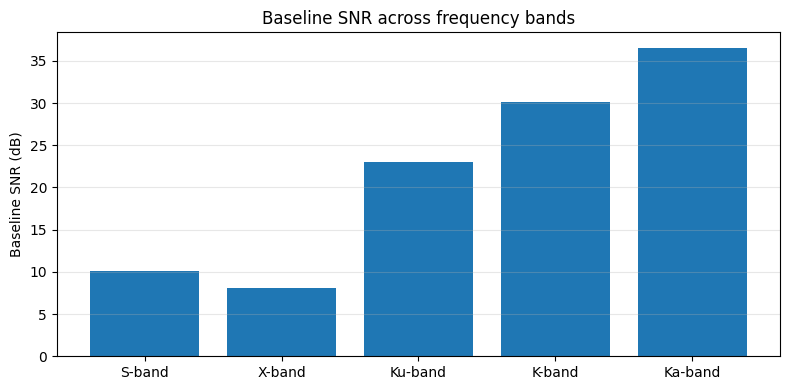

In [7]:
plt.figure(figsize=(8, 4))
plt.bar(df_results.index, df_results["Baseline SNR (dB)"])
plt.ylabel("Baseline SNR (dB)")
plt.title("Baseline SNR across frequency bands")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Interference-Induced Attenuation (ΔSNR)

The following plot compares the SNR degradation
caused by the same aggregate interference scenario
across all frequency bands.


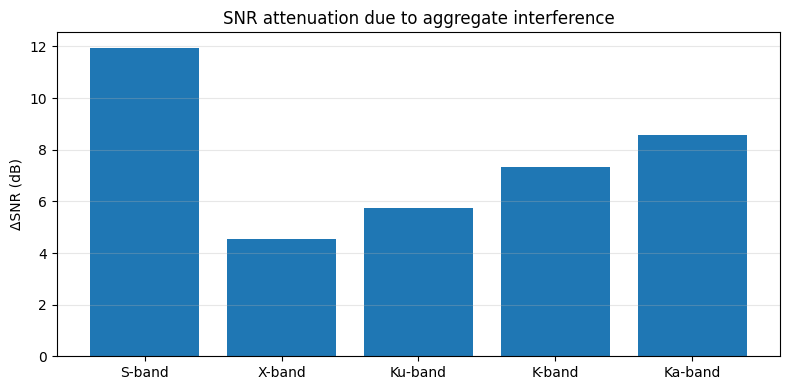

In [8]:
plt.figure(figsize=(8, 4))
plt.bar(df_results.index, df_results["SNR Loss (dB)"])
plt.ylabel("ΔSNR (dB)")
plt.title("SNR attenuation due to aggregate interference")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Cross-Band Sensitivity as a Function of Interferer Distance

To visualize how interference-induced attenuation scales with geometry,
a distance sweep is performed for each frequency band.

For each distance value:
- The same interferer EIRP and off-axis angle are used
- Aggregate interference is recomputed
- The resulting SNR loss (ΔSNR) is recorded

The results are presented as a heat map with:
- Vertical axis: frequency band
- Horizontal axis: interferer distance
- Color scale: ΔSNR in dB


In [9]:
# Distance sweep definition
distance_km = np.linspace(500, 40000, 40)

# Fixed interferer parameters (identical for all bands)
INTERFERER_TEMPLATE = {
    "EIRP_int_dbw": 20.0,
    "theta_off_axis_deg": 5.0,
    "sigma_db": 0.0,
    "duty_cycle": 1.0,
}

heatmap_data = []

for band, cfg in BAND_CONFIGS.items():
    band_losses = []

    for d in distance_km:
        interferer = INTERFERER_TEMPLATE.copy()
        interferer["d_km"] = d

        res = run_multi_entry_rfi_scenario(
            band_params=cfg,
            interferer_list=[interferer],
            time_sim_samples=2000,
        )

        band_losses.append(res["SNR Loss (dB)"])

    heatmap_data.append(band_losses)

heatmap_data = np.array(heatmap_data)


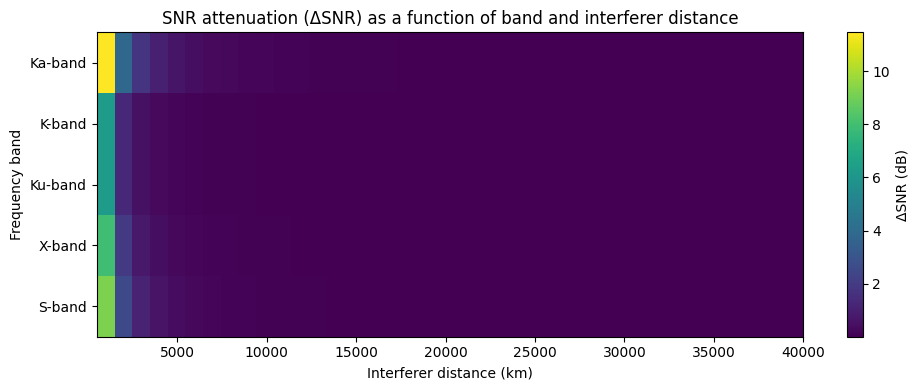

In [10]:
plt.figure(figsize=(10, 4))
im = plt.imshow(
    heatmap_data,
    aspect="auto",
    cmap="viridis",
    extent=[distance_km[0], distance_km[-1], 0, len(BAND_CONFIGS)],
)

plt.yticks(
    np.arange(len(BAND_CONFIGS)) + 0.5,
    list(BAND_CONFIGS.keys())
)
plt.xlabel("Interferer distance (km)")
plt.ylabel("Frequency band")
plt.title("SNR attenuation (ΔSNR) as a function of band and interferer distance")

cbar = plt.colorbar(im)
cbar.set_label("ΔSNR (dB)")

plt.tight_layout()
plt.show()


## 9. Cross-Band Sensitivity Across Interference Scenarios

To further isolate frequency-dependent effects,
multiple aggregate interference scenarios are defined,
ranging from weak to strong.

Each scenario is applied identically across all bands.
The resulting SNR loss is summarized in a second heat map.


In [11]:
INTERFERENCE_SCENARIOS = {
    "Weak": [
        {"EIRP_int_dbw": 5.0,  "d_km": 2000.0, "theta_off_axis_deg": 15.0},
    ],
    "Moderate": [
        {"EIRP_int_dbw": 15.0, "d_km": 1000.0, "theta_off_axis_deg": 7.5},
    ],
    "Strong": [
        {"EIRP_int_dbw": 25.0, "d_km": 500.0,  "theta_off_axis_deg": 3.0},
    ],
}


In [12]:
scenario_names = list(INTERFERENCE_SCENARIOS.keys())
scenario_matrix = []

for band, cfg in BAND_CONFIGS.items():
    band_row = []

    for scenario in scenario_names:
        res = run_multi_entry_rfi_scenario(
            band_params=cfg,
            interferer_list=INTERFERENCE_SCENARIOS[scenario],
            time_sim_samples=5000,
        )
        band_row.append(res["SNR Loss (dB)"])

    scenario_matrix.append(band_row)

scenario_matrix = np.array(scenario_matrix)


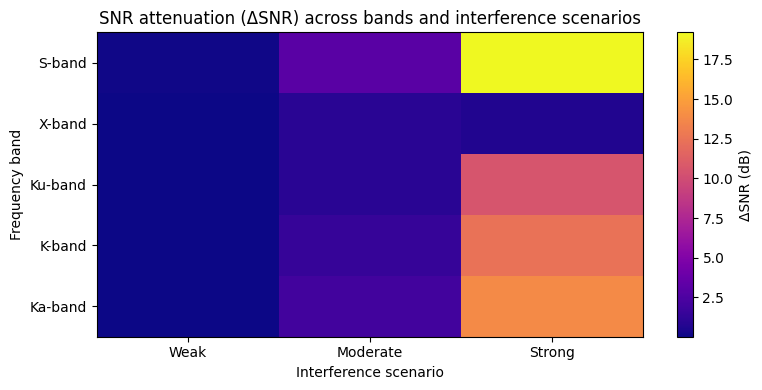

In [13]:
plt.figure(figsize=(8, 4))
im = plt.imshow(
    scenario_matrix,
    aspect="auto",
    cmap="plasma",
)

plt.xticks(
    np.arange(len(scenario_names)),
    scenario_names
)
plt.yticks(
    np.arange(len(BAND_CONFIGS)),
    list(BAND_CONFIGS.keys())
)

plt.xlabel("Interference scenario")
plt.ylabel("Frequency band")
plt.title("SNR attenuation (ΔSNR) across bands and interference scenarios")

cbar = plt.colorbar(im)
cbar.set_label("ΔSNR (dB)")

plt.tight_layout()
plt.show()


## 10. Dynamic X-band Case: SNR Loss vs Off-Axis Angle

To illustrate time-varying behavior,
a dynamic off-axis pass is simulated for the X-band reference link.

The interferer EIRP and distance are fixed,
while the off-axis angle varies smoothly,
representing a pass-by geometry.

This example highlights how ΔSNR evolves continuously
rather than as a static worst-case value.


In [14]:
x_cfg = BAND_CONFIGS["X-band"]

theta_series = generate_geometric_sweep(
    max_theta_deg=20.0,
    min_theta_deg=0.5,
    num_steps=400,
)

N_dbw = compute_thermal_noise_dbw(T_SYS_DEFAULT_K, BW_DEFAULT_HZ)
Lfs_carrier = free_space_path_loss_db(x_cfg["f_ghz"], DKM_GEO)

C_dbw = (
    x_cfg["EIRP_dbw"]
    - Lfs_carrier
    + x_cfg["G_rx_db"]
)

SNR_baseline = C_dbw - N_dbw


In [15]:
snr_loss_series = []

for theta in theta_series:
    g_rx = compute_off_axis_gain_s1528_db(
        g_max=x_cfg["G_rx_db"],
        theta_deg=theta,
        theta_3db=x_cfg["theta_3db"],
    )

    Lfs_int = free_space_path_loss_db(x_cfg["f_ghz"], 1000.0)

    I_dbw = (
        38.0
        - Lfs_int
        + g_rx
    )

    SNR_I = compute_snr_with_interference_db(C_dbw, N_dbw, I_dbw)
    snr_loss_series.append(SNR_baseline - SNR_I)

snr_loss_series = np.array(snr_loss_series)


**Note on scope:**  
This dynamic X-band example is intended solely to illustrate the effect of
time-varying off-axis geometry on instantaneous SNR and SNR attenuation.
It does not represent a complete aggregate interference scenario and does not
include multiple interferers or additional loss mechanisms.

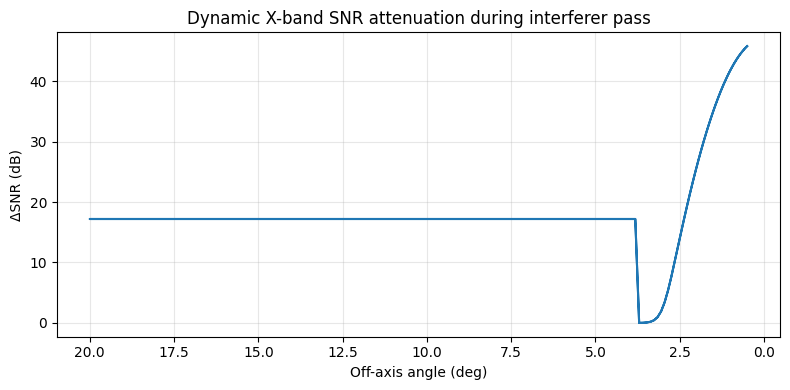

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(theta_series, snr_loss_series)
plt.gca().invert_xaxis()
plt.xlabel("Off-axis angle (deg)")
plt.ylabel("ΔSNR (dB)")
plt.title("Dynamic X-band SNR attenuation during interferer pass")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 11. Discussion

The results demonstrate clear frequency-dependent trends:

- Baseline SNR increases with frequency due to higher antenna gain and EIRP
- Interference-induced attenuation does not scale uniformly with baseline SNR
- Lower-frequency bands tend to experience larger relative degradation
  under identical interference assumptions
- Heat maps reveal strong sensitivity differences that are not visible
  from single-point evaluations

These results emphasize the importance of comparative,
band-aware analysis when assessing RFI impact on space communication links.
